In [1]:
# given a json file / collection of sentences - run some basic analysis

import json
import os
import re
import time
import gzip
import itertools


import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


try:
    # python package (nlp) location - two levels up from this file
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    # add package to sys.path if it's not already there
    if src_path not in sys.path:
        sys.path.extend([src_path])
except NameError:
    print('issue with adding to path, probably due to __file__ not being defined')
    src_path = None


from nlp.utils import get_database, niave_long_to_short_name, get_knowledge_base_from_value_chain_data
from nlp import get_configs_path, get_data_path


# Copy of sentence_analysis.py

## Load Data

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 70)

# ----
# parameters
# ----

# if True will read articles from local json file: data/articles.json
# - this can reduce burden on the remote database (network usage)
read_local_articles = True

# make number of sentences to combine
max_num_sentences_to_combine = 5

# ----
# connect to database
# ----

# get credentials
with open(get_configs_path("mongo.json"), "r+") as f:
    mdb_cred = json.load(f)

# get mongodb client - for connections
client = get_database(username=mdb_cred["username"],
                        password=mdb_cred["password"],
                        clustername=mdb_cred["cluster_name"])

# --
# get knowledge base
# --

# ---
# read in value chain data / knowledge base
# ---

vc = pd.DataFrame(list(client["refinitiv"]["VCHAINS"].find(filter={})))

# there are some missing comany names? exclude those
vc = vc.loc[~pd.isnull(vc['Company Name'])]

# the knowledge base
kb = get_knowledge_base_from_value_chain_data(vc)

# ---
# read in full_sentences store locally
# ---

assert os.path.exists(get_data_path("full_sentences.json")), \
    f"looks like: {get_data_path('full_sentences.json')}, copy from google drive data/full_sentences.json"

with open(get_data_path("full_sentences.json"), "r") as f:
    full_sents = json.load(f)

# ---
# read in article data - for reference
# ---

# read proof of concept data
assert os.path.exists(get_data_path("articles.json")), \
    f"{get_data_path('articles.json')} does not exist, get from the google drive and save locally"

with open(get_data_path("articles.json"), "r") as f:
    article_list = json.load(f)

articles = {re.sub("\.json$", "", f["json_file"]): f
            for f in article_list if "names_in_text" in f}


## Analysis

unique relations: ['Supplier' 'NA']
number of unique articles: 25372
count of 'relation'
          full_sentence
relation               
NA                62730
Supplier         100103
average extract sentences per article: 6.42


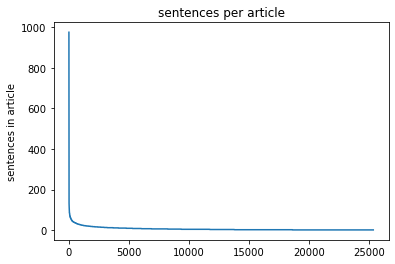

top articles:
                                                                article  \
10967  6d883e37fb28dc3c1c0fbf31b66e1f5792739276287cf62de8c3ca073ab686b4   
3144   20444599a6fcbdb691b43b71bd214872038e3ee1bf536b41953e8704e275da9f   
4187   2a5bca0630b5e105d5d15e1d6bb8deaf2e43ea1acc1b7f09c0d0cf7043a5e7a5   
5958   3bb0ac03a9a718cb6bb71f421658eba3ccc992fe905fd291eaf7bde5e1a61a97   
12788  805f831505530537d858a8335cfa498dec686a80cbfed406059369a90e3f2bff   
15834  9ef630d0db6211a326b886fff48af57954ca997f8cf68d3819968692a10eecff   
18965  be5bc7172e9f834ae1a90dab7a0fa3874bd165c5a19c198d34065266c09ec958   
15690  9dab9253e2cea5262f91e2917579b4551f225ef9c92908a2cf76655d0b454578   
15029  96bf0ca5d5e75b39875d1213ccaad9025071d50082b33937fe32b4d67636685e   
636    06960d7b41a670cb50a1f8e7107e514dd5c82c63c849957ad6ce87ec7d036e02   
14785  9459a56f211aeb103c214e03e9f961be0c71d00842ff2cea7e6cae16877d5b56   
1162   0bd3c52d7efada74fa318750007e052c0bcd5fe6221191daf3717fbc897ab623   
11460  728d

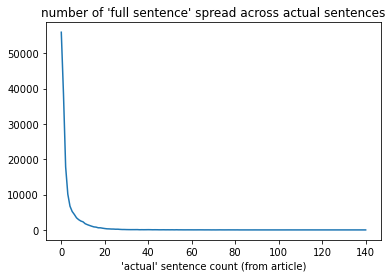

16.30939503205128

In [3]:
# ---
# get counts of occurrences / summary statistics
# ---

keys = list(full_sents[0].keys())

df = pd.DataFrame(full_sents)
# exclude the full_sentence - for now
# df.drop("full_sentence", axis=1, inplace=True)

print(f"unique relations: {df['relation'].unique()}")

print(f"number of unique articles: {len(df['article'].unique())}")

# ---
# count of relation
# ---
relation_count = pd.pivot_table(df,
                                index="relation",
                                values="full_sentence",
                                aggfunc="count")
print("count of 'relation'")
print(relation_count)

# ---
# sentences per articles
# ---

sent_per_art = pd.pivot_table(df, index='article', values="full_sentence", aggfunc='count')
sent_per_art = sent_per_art.reset_index()
sent_per_art.sort_values("full_sentence", ascending=False, inplace=True)

print(f"average extract sentences per article: {sent_per_art['full_sentence'].mean():.2f}")

plt.plot(sent_per_art['full_sentence'].values)
plt.title("sentences per article")
plt.ylabel("sentences in article")
plt.show()

# there is heavy skew
print("top articles:")
print(sent_per_art.head(20))

sent_per_art.loc[sent_per_art['full_sentence'] < 10, 'full_sentence'].mean()

# ---
# sentence spread - entity pair can exist across multiple sentence - consider those
# ---

num_sent = pd.pivot_table(df,
                            index='num_sentence',
                            values="full_sentence",
                            aggfunc="count")

plt.plot(num_sent)
plt.title("number of 'full sentence' spread across actual sentences")
plt.xlabel("'actual' sentence count (from article)")
plt.show()

# ---
# sentences per pair
# ---

sentence_per_triple = pd.pivot_table(df,
                                        index=["entity1", "entity2", "relation"],
                                        values=["full_sentence"],
                                        aggfunc="count").reset_index()

sentence_per_triple['full_sentence'].mean()


In [6]:
sentence_per_triple.sort_values('full_sentence',ascending=False)[:50]

,entity1,entity2,relation,full_sentence
3436,GM,Ford,Supplier,3751
3161,Ford,GM,Supplier,3751
7281,Samsung,Apple,NA,3679
724,Amazon,Apple,NA,2782
1109,Apple,Microsoft,Supplier,2755
1123,Apple,Qualcomm,Supplier,1536
8032,Sprint,T-Mobile,Supplier,1485
8239,T-Mobile,Sprint,Supplier,1485
1048,Apple,Alphabet,Supplier,1391
640,Alphabet,Amazon,Supplier,1141


In [8]:
sent_per_art[:50]

,article,full_sentence
10967,6d883e37fb28dc3c1c0fbf31b66e1f5792739276287cf62de8c3ca073ab686b4,975
3144,20444599a6fcbdb691b43b71bd214872038e3ee1bf536b41953e8704e275da9f,719
4187,2a5bca0630b5e105d5d15e1d6bb8deaf2e43ea1acc1b7f09c0d0cf7043a5e7a5,253
5958,3bb0ac03a9a718cb6bb71f421658eba3ccc992fe905fd291eaf7bde5e1a61a97,241
12788,805f831505530537d858a8335cfa498dec686a80cbfed406059369a90e3f2bff,236
15834,9ef630d0db6211a326b886fff48af57954ca997f8cf68d3819968692a10eecff,220
18965,be5bc7172e9f834ae1a90dab7a0fa3874bd165c5a19c198d34065266c09ec958,212
15690,9dab9253e2cea5262f91e2917579b4551f225ef9c92908a2cf76655d0b454578,210
15029,96bf0ca5d5e75b39875d1213ccaad9025071d50082b33937fe32b4d67636685e,165
636,06960d7b41a670cb50a1f8e7107e514dd5c82c63c849957ad6ce87ec7d036e02,157


In [13]:
#Look at number of sentences between entities

<AxesSubplot:>

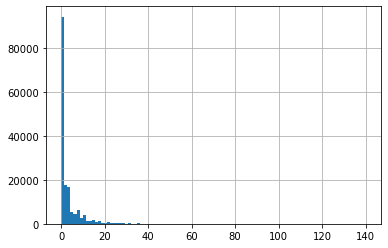

In [12]:
df['num_sentence'].hist(bins=100)

In [22]:
df.sort_values('num_sentence',ascending=False)[:20]

,full_sentence,entity1,entity2,relation,entity1_full,entity2_full,num_sentence,article
162757,"Twitter, which has been struggling with slowing user growth, is ex...",SunPower,Twitter,NA,SunPower Corp,Twitter Inc,140,c9554a1756f02785cc29bd8e5ce2844f7d04a8a3c363b2eff42b997718a24cfe
162756,"Exxon Mobil, the world’s biggest listed oil company, and its U.S. ...",SunPower,Chevron,NA,SunPower Corp,Chevron Corp,135,c9554a1756f02785cc29bd8e5ce2844f7d04a8a3c363b2eff42b997718a24cfe
162718,"Exxon Mobil, the world’s biggest listed oil company, and its U.S. ...",Exxon Mobil,SunPower,NA,Exxon Mobil Corp,SunPower Corp,135,c9554a1756f02785cc29bd8e5ce2844f7d04a8a3c363b2eff42b997718a24cfe
162708,"Procter & Gamble and Colgate-Palmolive Co, the two U.S. personal c...",Procter & Gamble,SunPower,NA,Procter & Gamble Co,SunPower Corp,133,c9554a1756f02785cc29bd8e5ce2844f7d04a8a3c363b2eff42b997718a24cfe
30998,Akamai Earnings Release 30-Apr-2018 AMC REG.N Regency Centers Corp...,Akamai,Skyworks Solutions,NA,Akamai Technologies Inc,Skyworks Solutions Inc,125,84a15e2dba555fed1300e4b5208e5082f22637d260599af9d3c6b5e746aca4bb
30997,Akamai Earnings Release 30-Apr-2018 AMC REG.N Regency Centers Corp...,Akamai,Activision,NA,Akamai Technologies Inc,Activision Blizzard Inc,125,84a15e2dba555fed1300e4b5208e5082f22637d260599af9d3c6b5e746aca4bb
70371,Microsoft is expected to report second-quarter revenue slightly ab...,Volkswagen,Microsoft,Supplier,Volkswagen AG,Microsoft Corp,117,2b5a455f8202cd978843043cdf7331b93d1f692d47493e567d1b801d8eb2dcd0
31014,Emerson Q2 2018 Emerson Earnings Release 01-May-2018 BMO NBL.N Nob...,Skyworks Solutions,Emerson,NA,Skyworks Solutions Inc,Emerson Electric Co,114,84a15e2dba555fed1300e4b5208e5082f22637d260599af9d3c6b5e746aca4bb
31007,Emerson Q2 2018 Emerson Earnings Release 01-May-2018 BMO NBL.N Nob...,Activision,Emerson,NA,Activision Blizzard Inc,Emerson Electric Co,114,84a15e2dba555fed1300e4b5208e5082f22637d260599af9d3c6b5e746aca4bb
70311,Microsoft is expected to report second-quarter revenue slightly ab...,Microsoft,Harman,Supplier,Microsoft Corp,Harman International Industries Inc,114,2b5a455f8202cd978843043cdf7331b93d1f692d47493e567d1b801d8eb2dcd0


In [34]:
df_short_dist = df.loc[df["num_sentence"]<3,:] 

print("{}% articles have max 1 sentence in between two entity mentions".format(np.round(df.loc[df["num_sentence"]<3,:].shape[0]/df.shape[0],2)*100))
print("{} out of {} sentences left".format(df.loc[df["num_sentence"]<3,:].shape[0],df.shape[0]))



69.0% articles have max 1 sentence in between two entity mentions
112338 out of 162833 sentences left


In [37]:
label = np.ones(df_short_dist.shape[0]).astype(int)
label[df_short_dist['relation']=="NA"] = 0
df_short_dist.loc[:,'label'] = label
df_short_dist.head()

/var/folders/tg/p6cnrdn143z3tt8bjg0h_qcw0000gn/T/ipykernel_31374/2453559823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short_dist.loc[:,'label'] = label


,full_sentence,entity1,entity2,relation,entity1_full,entity2_full,num_sentence,article,label
1,These reviews have been especially popular with companies like App...,Samsung,Apple,NA,Samsung Electronics Co Ltd,Apple Inc,0,50b8f1a67bb7c2cab2fe56b55a24f59ad1703c07b7053e939de52aea051d34c3,0
4,April 24 (Reuters) - Bharti Airtel posted its lowest quarterly pro...,Reliance,Bharti Airtel,NA,Reliance Industries Ltd,Bharti Airtel Ltd,1,603eeb451da67a70850a823e4eb4e1221a5358040bde3bc85005c4c7028a3a42,0
5,"The entry of Reliance Jio, the telecoms arm of Reliance, into Indi...",Reliance,Bharti Airtel,NA,Reliance Industries Ltd,Bharti Airtel Ltd,2,603eeb451da67a70850a823e4eb4e1221a5358040bde3bc85005c4c7028a3a42,0
8,All that is required to have packages delivered to a car is downlo...,Amazon,GM,Supplier,Amazon.com Inc,General Motors Co,0,884c15dbfd38525ffd89c79ae9f247ac828382bf39e2e2a776fe4738fa087bf6,1
9,All that is required to have packages delivered to a car is downlo...,Amazon,GM,Supplier,Amazon.com Inc,General Motors Co,2,884c15dbfd38525ffd89c79ae9f247ac828382bf39e2e2a776fe4738fa087bf6,1


In [44]:
df_short_dist.iloc[1,0]

'April 24 (Reuters) - Bharti Airtel posted its lowest quarterly profit in nearly 15 years on Tuesday, as a price war in the telecoms sector continued to hurt, while revenue was hit by a regulatory cut in international termination charges. The entry of Reliance Jio, the telecoms arm of Reliance, into India’s telecoms sector has set off a brutal price war among operators as they drastically cut prices to compete with Jio’s bottomed out plans.'

# Store file sentences for later use

In [47]:
df_short_dist.to_csv(get_data_path() + "/sentences_short_dist.tsv",sep='\t')